# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [1]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [2]:
# TODO: load the air temperature and precipitation datasets.
# Example: air = xr.open_dataset(..., chunks={"time": 8})
air = xr.open_dataset("air.sig995.2020.nc", chunks={"time": 8})
precip = xr.open_dataset("precip.2020.nc", chunks={"time": 8})



## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [3]:
lat_slice = slice(LAT_RANGE[1], LAT_RANGE[0])  # reverse: 50 to 20
lon_slice = slice(LON_RANGE_360[0], LON_RANGE_360[1])  # normal: 230 to 300

air_us = air.sel(lat=lat_slice, lon=lon_slice, time=TIME_RANGE)
precip_us = precip.sel(lat=lat_slice, lon=lon_slice, time=TIME_RANGE)




## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [4]:
# TODO: use xr.resample to create daily means.
air_daily = air_us["air"].resample(time="1D").mean()


## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [5]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.
air_interp = air_daily.interp(
    lat=precip_us.lat,
    lon=precip_us.lon
)



In [6]:
print(precip_us.lat.shape)
print(precip_us.lon.shape)
print(precip.lat[0].values, precip.lat[-1].values)
#lat_slice = slice(LAT_RANGE[1], LAT_RANGE[0])  # reverse: 50 to 20



(60,)
(140,)
89.75 -89.75


## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [7]:
# TODO: build datasets and merge them into one object named `merged`.
air_ds = air_interp.to_dataset(name="air_temperature")
precip_ds = precip_us["precip"].to_dataset(name="daily_precip")
merged = xr.merge([air_ds, precip_ds])



## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [8]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)



<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


/opt/conda/envs/xarray-climate/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/envs/xarray-climate/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


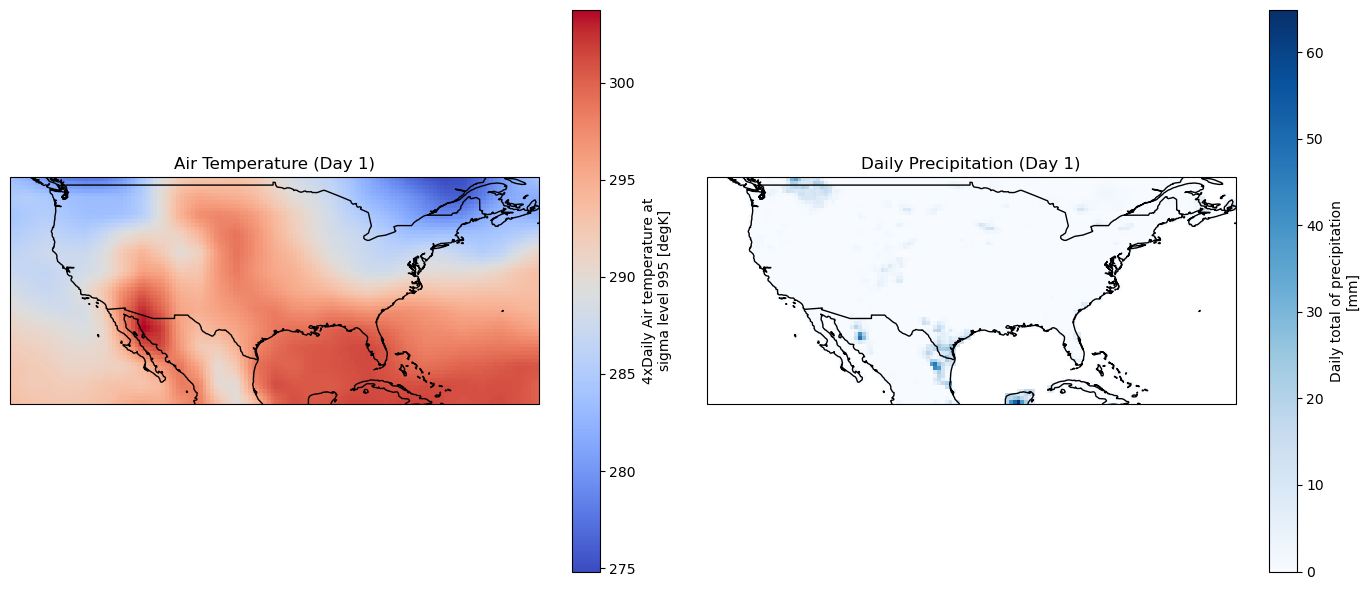

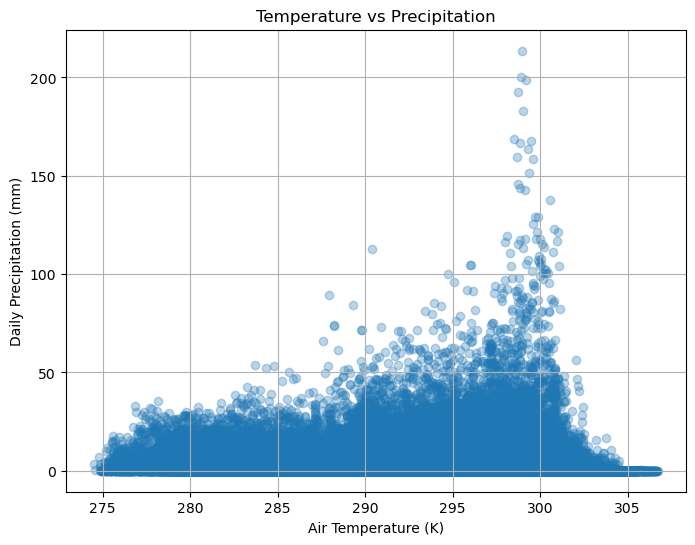

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": ccrs.PlateCarree()})
merged.air_temperature.isel(time=0).plot(ax=axs[0], transform=ccrs.PlateCarree(), cmap="coolwarm")
axs[0].set_title("Air Temperature (Day 1)")
merged.daily_precip.isel(time=0).plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap="Blues")
axs[1].set_title("Daily Precipitation (Day 1)")
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
plt.tight_layout()
plt.show()

temp_vals = merged.air_temperature.values.flatten()
precip_vals = merged.daily_precip.values.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(temp_vals, precip_vals, alpha=0.3)
plt.xlabel("Air Temperature (K)")
plt.ylabel("Daily Precipitation (mm)")
plt.title("Temperature vs Precipitation")
plt.grid(True)
plt.show()

merged.to_netcdf("merged_climate_data.nc")
